# Joint RV & transit fits, TOI 1273

In [1]:
# Our tools
import exoplanet as xo
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import lightkurve as lk
from astropy.io import fits
from astropy.timeseries import BoxLeastSquares


import pymc3 as pm
import aesara_theano_fallback.tensor as tt
import pymc3_ext as pmx

import os
import warnings
os.environ["MKL_THREADING_LAYER"] = "GNU"
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

plt.rcParams["figure.figsize"]=8,6
plt.rcParams.update({'font.size': 16})

## Datasets and initializations
Lets start with the transits from TESS

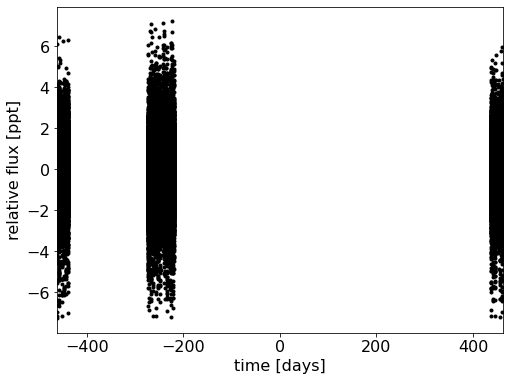

In [2]:
lc_file = lk.search_lightcurve('TIC 445859771', author='SPOC').download_all(flux_column="pdcsap_flux")
lc = lc_file.stitch().remove_nans().normalize().remove_outliers()
time = lc.time.value
flux = lc.flux


with fits.open(lc_file[0].filename) as hdu:
    hdr = hdu[1].header

texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

ref_time = 0.5 * (np.min(time) + np.max(time))
x_ = np.ascontiguousarray(time - ref_time, dtype=np.float64)
y_ = np.ascontiguousarray(1e3 * (flux - 1.0), dtype=np.float64)
yerr = np.ascontiguousarray(1e3 * lc.flux_err, dtype=np.float64)

plt.plot(x_, y_, ".k")
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
_ = plt.xlim(x_.min(), x_.max())
#plt.savefig('tessdata_1199.png',dpi=300,bbox_inches='tight')

In [3]:
period_grid = np.exp(np.linspace(np.log(1), np.log(15), 50000))

bls = BoxLeastSquares(x_, y_, yerr)
bls_power = bls.power(period_grid, 0.1, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = bls.transit_mask(x_, bls_period, 0.2, bls_t0)

print('bls period:',bls_period)
print('bls t0:',bls_t0)
print('bls depth:',bls_depth)
print('ref_time:', ref_time)
print('epoch:', bls_t0 + ref_time)

bls period: 4.631316790471438
bls t0: -461.34256457198444
bls depth: 2.062291019979162
ref_time: 2173.6753273248096
epoch: 1712.3327627528251


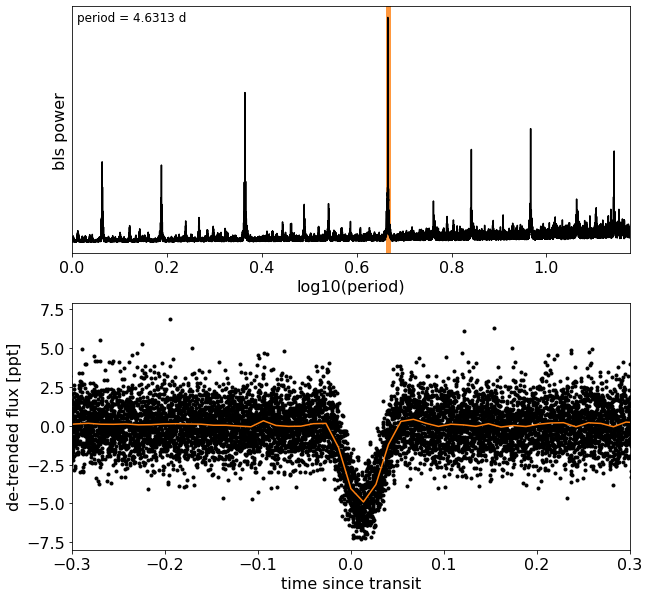

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_period), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power.period), bls_power.power, "k")
ax.annotate(
    "period = {0:.4f} d".format(bls_period),
    (0, 1),
    xycoords="axes fraction",
    xytext=(5, -5),
    textcoords="offset points",
    va="top",
    ha="left",
    fontsize=12,
)
ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel("log10(period)")

# Plot the folded transit
ax = axes[1]
x_fold_ = (x_ - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
m = np.abs(x_fold_) < 0.4
ax.plot(x_fold_, y_, ".k")

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 62)
denom, _ = np.histogram(x_fold_, bins)
num, _ = np.histogram(x_fold_, bins, weights=y_)
denom[num == 0] = 1.0
ax.plot(0.5 * (bins[1:] + bins[:-1]), num / denom, color="C1")

ax.set_xlim(-0.3, 0.3)
ax.set_ylabel("de-trended flux [ppt]")
_ = ax.set_xlabel("time since transit")
#plt.savefig('bls_1199.png',dpi=300,bbox_inches='tight')

(-0.12, 0.12)

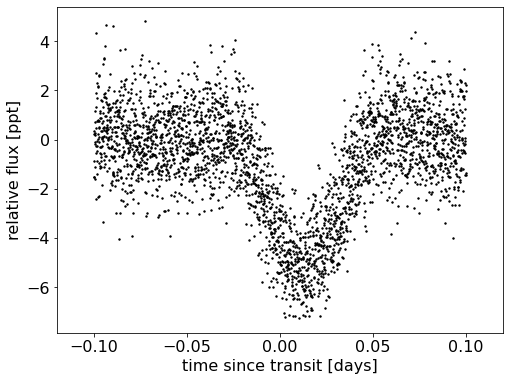

In [9]:
x_fold_ = (x_ - bls_t0 + 0.5*bls_period) % bls_period - 0.5*bls_period

# Me quedo solo con los puntos cerca de los transitos
x_fold = x_fold_[transit_mask]
x = x_[transit_mask]
y = y_[transit_mask]

plt.scatter(x_fold, y, c='k', s=2)
plt.xlabel("time since transit [days]")
plt.ylabel("relative flux [ppt]");
plt.xlim(-0.12,0.12)

Now the SOPHIE RVs.

46


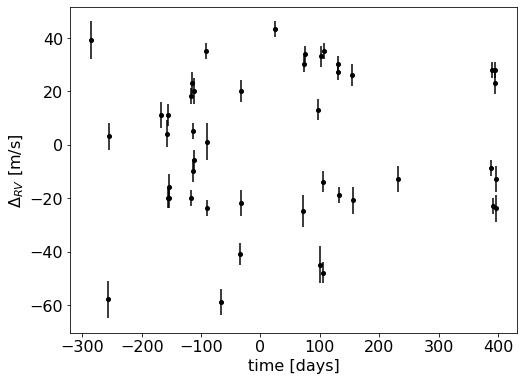

In [21]:
data = pd.read_table('1273_preliminary_rv_sophie.dat', sep='\s+')
data.rename(columns={'rv(km/s)': 'rv', 'sigRV(km/s)':'err'}, inplace=True)

x_rv = np.array(data.bjd-2457000)-ref_time
y_rv = np.array((data.rv-data.rv.mean())*1000)
yerr_rv = np.array(data.err*1000)

plt.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k", markersize=8)
plt.xlabel("time [days]")
print(len(x_rv))
_ = plt.ylabel("$\Delta_{RV}$ [m/s]")

Estimate the planet minimum mass and the semiamplitude.

In [12]:
import exoplanet as xo
import astropy.units as u

# Stellar parameters from Sousa
M_star = 0.98, 0.02
R_star = 1.07, 0.03

K = xo.estimate_semi_amplitude(bls_period, x_rv, y_rv, yerr_rv, t0s=bls_t0)
print('K=', K, "m/s")

msini = xo.estimate_minimum_mass(bls_period, x_rv, y_rv, yerr_rv, t0s=bls_t0, m_star=M_star[0])
msini = msini.to(u.M_earth)
print('minimum mass=', msini)

[80.72751866] earthMass


## Joint transit and radial velocity model in PyMC3

Now, let's define our full model in *PyMC3*.

In [24]:
# These arrays are used as the times/phases where the models are
# evaluated at higher resolution for plotting purposes 
t_rv = np.linspace(x_rv.min() - 5, x_rv.max() + 5, 3000)
phase_lc = np.linspace(-0.3, 0.3, 150)


def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:
        
        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=5.0)
        u_star = xo.QuadLimbDark("u_star")
        star = xo.LimbDarkLightCurve(u_star)

        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal("m_star", mu=M_star[0], sd=M_star[1])
        r_star = BoundedNormal("r_star", mu=R_star[0], sd=R_star[1])

        # Orbital parameters for the planets
        t0 = pm.Normal("t0", mu=bls_t0, sd=1)
        log_m_pl = pm.Normal("log_m_pl", mu=np.log(msini.value[0]), sd=1)
        log_period = pm.Normal("log_period", mu=np.log(bls_period), sd=1)

        # Fit in terms of transit depth (assuming b<1)
        b = pm.Uniform("b", lower=0, upper=1)
        log_depth = pm.Normal("log_depth", mu=np.log(bls_depth), sigma=2.0)
        ror = pm.Deterministic(
            "ror",
            star.get_ror_from_approx_transit_depth(
                1e-3 * tt.exp(log_depth), b
            ),
        )
        r_pl = pm.Deterministic("r_pl", ror * r_star)

        m_pl = pm.Deterministic("m_pl", tt.exp(log_m_pl))
        period = pm.Deterministic("period", tt.exp(log_period))

        ecs = pmx.UnitDisk("ecs", testval=np.array([0.01, 0.01]))
        ecc = pm.Deterministic("ecc", tt.sum(ecs**2))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
        xo.eccentricity.kipping13("ecc_prior", fixed=True, observed=ecc)

        # RV jitter & a quadratic RV trend
        log_sigma_rv = pm.Normal("log_sigma_rv", mu=np.log(np.median(yerr_rv)), sd=5)
        trend = pm.Normal("trend", mu=0, sd=10.0 ** -np.arange(3)[::-1], shape=3)  # [2,1,0]

        # Transit jitter
        logs = pm.Uniform("logs", lower=0, upper=1,testval=np.log(np.std(y)))

        # Wide log-normal prior for semi-amplitude
        #logK = pm.Normal("logK", mu=np.log(K.item()), sd=2.0)

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            m_star=m_star,
            period=period,
            t0=t0,
            b=b,
            m_planet=xo.units.with_unit(m_pl, msini.unit),
            ecc=ecc,
            omega=omega,
        )

        # Compute the model light curve
        light_curves = (star.get_light_curve(orbit=orbit, r=r_pl, t=x[mask], texp=texp)* 1e3)
        light_curve = tt.sum(light_curves, axis=-1) + mean
        resid = y[mask] - light_curve

        # The likelihood for the light curve
        pm.Normal("transit_obs", mu=light_curve, sd=tt.exp(logs), observed=y[mask])

        # Compute a reference time that will be used to normalize the trends model
        x_ref = 0.5 * (x_rv.min() + x_rv.max())
        # And a function for computing the full RV model
        def get_rv_model(t, name=""):
            # First the RVs induced by the planet
            #vrad = orbit.get_radial_velocity(t, K=tt.exp(logK))
            vrad = orbit.get_radial_velocity(t)
            pm.Deterministic("vrad" + name, vrad)

            # Define the background model
            A = np.vander(t - x_ref, 3) # Generate a Vandermonde matrix with t-x_ref as input vector
            bkg = pm.Deterministic("bkg" + name, tt.dot(A, trend))

            # Sum planet and background to get the full model
            return pm.Deterministic("rv_model" + name, vrad + bkg)


        # Define the model
        rv_model = get_rv_model(x_rv)
        get_rv_model(t_rv, name="_pred")

        # The likelihood for the RVs
        err = tt.sqrt(yerr_rv**2 + tt.exp(2 * log_sigma_rv))
        pm.Normal("obs", mu=rv_model, sd=err, observed=y_rv)


        # Compute and save the phased light curve models
        pm.Deterministic("lc_pred",
            1e3 * star.get_light_curve(orbit=orbit, r=r_pl, t=t0 + phase_lc, texp=texp)[..., 0],)

        # Fit for the maximum a posteriori parameters
        if start is None:
            start = model.test_point
        map_soln = pmx.optimize(start=start, vars=[trend])
        map_soln = pmx.optimize(start=map_soln, vars=[logs])
        map_soln = pmx.optimize(start=map_soln, vars=[t0, log_period])
        map_soln = pmx.optimize(start=map_soln, vars=[u_star])
        map_soln = pmx.optimize(start=map_soln, vars=[ecs])
        map_soln = pmx.optimize(start=map_soln, vars=[log_m_pl])
        map_soln = pmx.optimize(start=map_soln, vars=[log_depth, b])
        map_soln = pmx.optimize(start=map_soln, vars=[log_sigma_rv])
        map_soln = pmx.optimize(start=map_soln, vars=[mean])
        map_soln = pmx.optimize(start=map_soln)

        extras = pmx.eval_in_model(light_curves, map_soln)

    return model, map_soln, extras

model0, map_soln0, extras0 = build_model()

optimizing logp for variables: [trend]


message: Optimization terminated successfully.
logp: -6998.806339895237 -> -6993.175291545694
optimizing logp for variables: [logs]


message: Optimization terminated successfully.
logp: -6993.175291545694 -> -6972.495010386972
optimizing logp for variables: [log_period, t0]


message: Desired error not necessarily achieved due to precision loss.
logp: -6972.495010386971 -> -6969.566795377631
optimizing logp for variables: [u_star]


message: Optimization terminated successfully.
logp: -6969.56679537763 -> -6767.541964986179
optimizing logp for variables: [ecs]


message: Desired error not necessarily achieved due to precision loss.
logp: -6767.541964986179 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model
optimizing logp for variables: [log_m_pl]


message: Optimization terminated successfully.
logp: -6767.541964986177 -> -6741.683921245023
optimizing logp for variables: [b, log_depth]


message: Desired error not necessarily achieved due to precision loss.
logp: -6741.683921245023 -> -6332.519677929176
optimizing logp for variables: [log_sigma_rv]


message: Optimization terminated successfully.
logp: -6332.519677929176 -> -6299.847836431683
optimizing logp for variables: [mean]


message: Optimization terminated successfully.
logp: -6299.847836431683 -> -6294.2944458451075
optimizing logp for variables: [logs, trend, log_sigma_rv, ecs, log_depth, b, log_period, log_m_pl, t0, r_star, m_star, u_star, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -6294.294445845107 -> -5221.263604133348


Now let's plot the map radial velocity model.

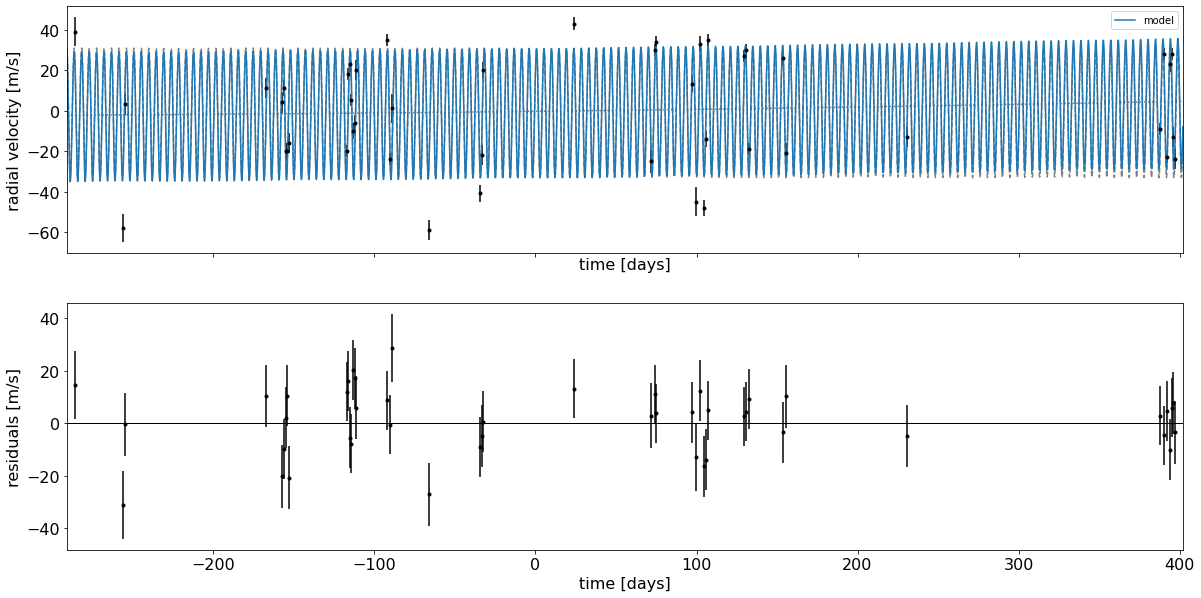

In [26]:
# We plot the initial model:
def plot_rv_curve(soln):
    fig, axes = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
    ax = axes[0]
    ax.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
    ax.plot(t_rv, soln['vrad_pred'], "--k", alpha=0.5)
    ax.plot(t_rv, soln['bkg_pred'], ":k", alpha=0.5)
    ax.plot(t_rv, soln['rv_model_pred'], label="model")
    ax.legend(fontsize=10)
    ax.set_xlabel("time [days]")
    ax.set_ylabel("radial velocity [m/s]")
    
    ax = axes[1]
    err = np.sqrt(yerr_rv**2 + np.exp(2 * soln["log_sigma_rv"]))
    ax.errorbar(x_rv, y_rv - soln["rv_model"], yerr=err, fmt=".k")
    ax.axhline(0, color="k", lw=1)
    ax.set_ylabel("residuals [m/s]")
    ax.set_xlim(t_rv.min(), t_rv.max())
    #ax.set_xlim(2200,2300)
    ax.set_xlabel("time [days]")

_ = plot_rv_curve(map_soln0)

Now let's also plot the transit model.

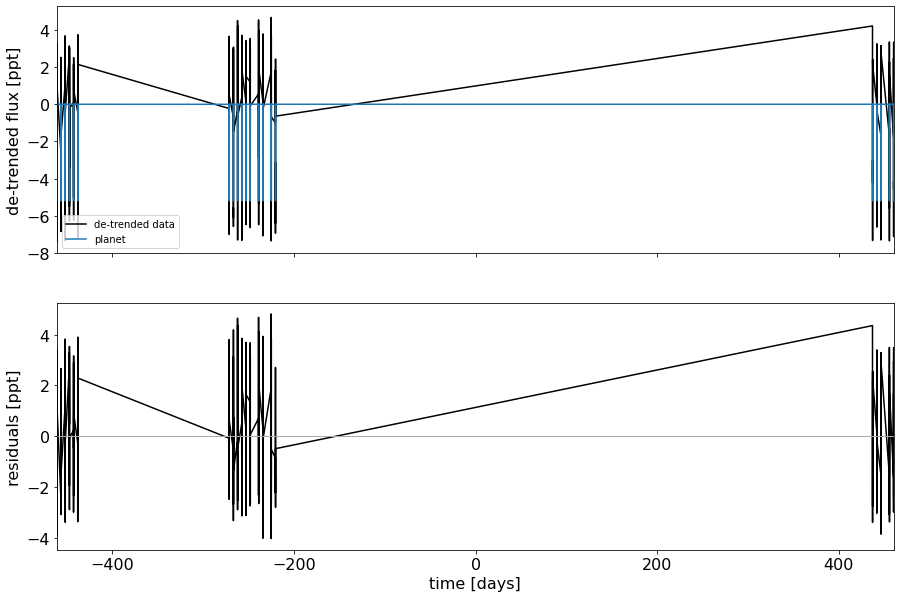

In [27]:
# We plot the initial light curve model:
def plot_light_curve(soln, extras, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask] - soln['mean'], "k", label="de-trended data")
    mod = extras
    ax.plot(x[mask], mod, label="planet")
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[1]
    mod = np.sum(extras, axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    #plt.xlim(-93,-92)
    return fig


_ = plot_light_curve(map_soln0, extras0)

## Sigma clipping

To remove the outliers, we'll look at the empirical RMS of the residuals away from the transit model and remove anything that is more than a 7-sigma outlier.

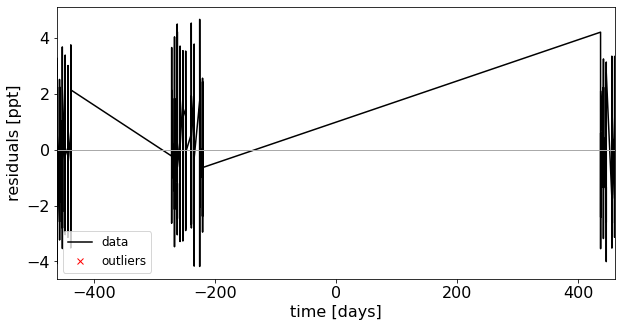

In [28]:
# We can do some sigma clipping to remove significant outliers.
mod = (map_soln0["mean"] + np.sum(extras0, axis=-1))

resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 7 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
_ = plt.xlim(x.min(), x.max())
#plt.xlim(-450,-435)

Let's re-build our model with this sigma-clipped dataset.

optimizing logp for variables: [trend]


message: Desired error not necessarily achieved due to precision loss.
logp: -5221.263604133346 -> -5221.263604133346
optimizing logp for variables: [logs]


message: Optimization terminated successfully.
logp: -5221.263604133346 -> -5221.263604133346
optimizing logp for variables: [log_period, t0]


message: Desired error not necessarily achieved due to precision loss.
logp: -5221.263604133348 -> -5221.263604133348
optimizing logp for variables: [u_star]


message: Optimization terminated successfully.
logp: -5221.263604133346 -> -5221.263604133346
optimizing logp for variables: [ecs]


message: Optimization terminated successfully.
logp: -5221.263604133346 -> -5221.263604133346
optimizing logp for variables: [log_m_pl]


message: Optimization terminated successfully.
logp: -5221.263604133348 -> -5221.263604133348
optimizing logp for variables: [b, log_depth]


message: Optimization terminated successfully.
logp: -5221.263604133346 -> -5221.263604133345
optimizing logp for variables: [log_sigma_rv]


message: Optimization terminated successfully.
logp: -5221.263604133345 -> -5221.263604133345
optimizing logp for variables: [mean]


message: Optimization terminated successfully.
logp: -5221.263604133345 -> -5221.263604133335
optimizing logp for variables: [logs, trend, log_sigma_rv, ecs, log_depth, b, log_period, log_m_pl, t0, r_star, m_star, u_star, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -5221.263604133337 -> -5221.263604133337


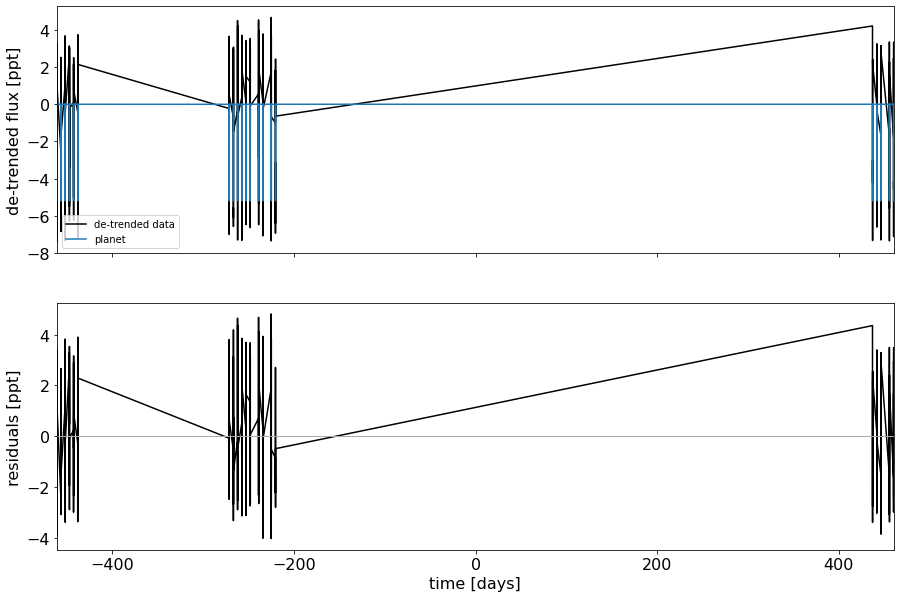

In [29]:
# looks like we don't have any outliers 
model, map_soln, extras = build_model(mask, map_soln0)
_ = plot_light_curve(map_soln, extras, mask)

Great! Now we're ready to sample.

## Sampling

In [66]:
import multiprocessing

with model:
    trace = pm.sample(
        tune=2000, #1500,
        draws=1500, #1000,
        start=map_soln,
        cores=4,
        chains=4,
        target_accept=0.95,
        return_inferencedata=True,
        random_seed=[203771098, 203775000, 261136679, 261136680],
        #mp_ctx=multiprocessing.get_context("fork"),
        init="adapt_full",
    )

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logs, trend, log_sigma_rv, ecs, log_depth, b, log_period, log_m_pl, t0, r_star, m_star, u_star, mean]


Sampling 4 chains for 2_000 tune and 1_500 draw iterations (8_000 + 6_000 draws total) took 3684 seconds.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Let's look at the convergence diagnostics for some of the key parameters:

In [84]:
import arviz as az

az.summary(
    trace,
    var_names=[
        "period",
        't0',
        "r_pl",
        "m_pl",
        "ecc",
        "omega",
        "b",
        "u_star",
        "trend",
        'ecs',
        'm_star',
        'r_star'
    ],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
period,4.631,0.000,4.631,4.631,0.000,0.000,5019.0,3967.0,1.0
t0,-461.329,0.000,-461.330,-461.328,0.000,0.000,4811.0,3576.0,1.0
r_pl,0.117,0.014,0.092,0.142,0.000,0.000,1319.0,1637.0,1.0
m_pl,81.777,6.537,68.775,93.547,0.094,0.067,4984.0,3197.0,1.0
ecc,0.045,0.032,0.000,0.103,0.000,0.000,4425.0,4785.0,1.0
omega,0.732,2.014,-2.891,3.141,0.040,0.028,3888.0,5405.0,1.0
b,0.966,0.020,0.931,0.999,0.001,0.000,1292.0,1291.0,1.0
u_star[0],0.690,0.431,0.001,1.412,0.007,0.005,3849.0,3850.0,1.0
u_star[1],0.065,0.421,-0.668,0.810,0.007,0.005,2964.0,2823.0,1.0
trend[0],0.000,0.000,-0.000,0.000,0.000,0.000,5817.0,3988.0,1.0


In [ ]:
#tune 3500, draws 2000, 2 chains, 2 cores
#           mean	sd	hdi_3%	hdi_97%	mcse_mean	mcse_sd	ess_bulk	ess_tail	r_hat
# period	4.631	0.000	4.631	4.631	0.000	0.000	4418.0	3025.0	1.0
# r_pl	    0.117	0.014	0.091	0.143	0.000	0.000	871.0	1412.0	1.0
# m_pl	    81.954	6.252	70.147	93.846	0.102	0.072	3744.0	2496.0	1.0
# ecc	    0.045	0.032	0.000	0.100	0.001	0.000	2150.0	3181.0	1.0
# omega	    0.729	2.001	-2.860	3.135	0.050	0.035	2106.0	1153.0	1.0
# b	        0.966	0.020	0.931	1.000	0.001	0.000	648.0	354.0	1.0
# u_star[0]	0.684	0.429	0.001	1.403	0.008	0.006	2374.0	2223.0	1.0
# u_star[1]	0.076	0.421	-0.723	0.762	0.009	0.007	2162.0	2154.0	1.0
# trend[0]	0.000	0.000	-0.000	0.000	0.000	0.000	2496.0	1135.0	1.0
# trend[1]	0.009	0.010	-0.007	0.028	0.000	0.000	3188.0	2824.0	1.0
# trend[2]	0.311	0.930	-1.413	2.068	0.017	0.014	2988.0	2951.0	1.0

In [ ]:

#           mean	sd	hdi_3%	hdi_97%	mcse_mean	mcse_sd	ess_bulk	ess_tail	r_hat
# period	4.631	0.000	4.631	4.631	0.000	0.000	1166.0	1359.0	1.01
# r_pl	    0.117	0.015	0.093	0.142	0.002	0.001	70.0	148.0	1.04
# m_pl	    81.365	6.331	70.156	93.038	0.412	0.292	251.0	1345.0	1.01
# ecc	    0.042	0.032	0.000	0.098	0.003	0.002	121.0	559.0	1.02
# omega	    0.770	1.883	-2.963	3.007	0.065	0.077	967.0	1393.0	1.01
# b	        0.967	0.020	0.933	0.998	0.002	0.001	94.0	392.0	1.03
# u_star[0]	0.720	0.454	0.004	1.431	0.044	0.033	170.0	787.0	1.02
# u_star[1]	0.022	0.438	-0.652	0.808	0.042	0.030	142.0	1058.0	1.02
# trend[0]	0.000	0.000	-0.000	0.000	0.000	0.000	1505.0	1103.0	1.01
# trend[1]	0.011	0.011	-0.009	0.028	0.001	0.001	77.0	237.0	1.04
# trend[2]	0.295	0.921	-1.416	2.127	0.023	0.027	1601.0	1207.0	1.01

In [68]:
radio = trace.posterior["r_pl"].mean().item()*109.076
radio_err = trace.posterior["r_pl"].std().item()*109.076
periodo = trace.posterior['period'].mean().item()
periodo_sigma = trace.posterior['period'].std().item()
t_0 = trace.posterior['t0'].mean().item()+ref_time
t_0_sigma = trace.posterior['t0'].std().item()
print("Radio = {r:.3f} \u00B1 {r_err:.3f}".format(r=radio, r_err=radio_err))
print("Periodo = {p:.6f} \u00B1 {p_s:.6f}".format(p=periodo, p_s=periodo_sigma))
print("Epoca = {e:.5f} \u00B1 {e_s:.4f}".format(e=t_0, e_s=t_0_sigma))

Radio = 12.737 ± 1.530
Periodo = 4.631301 ± 0.000003
Epoca = 1712.34651 ± 0.0004


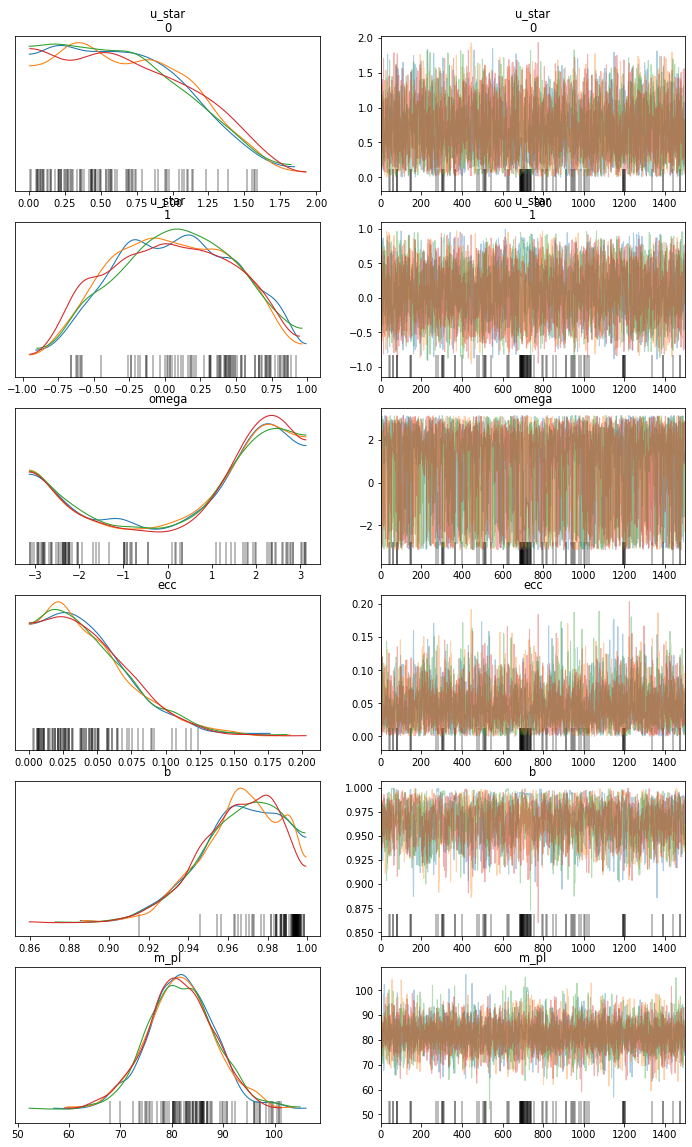

In [76]:
from arviz.utils import Numba
Numba.disable_numba()
Numba.numba_flag

_ = az.plot_trace(trace, var_names=['u_star', 'omega', 'ecc', 'b', 'm_pl'], compact=False, figsize=(12,20))
#plt.savefig('trace_joint_1273.png',dpi=200,bbox_inches='tight')

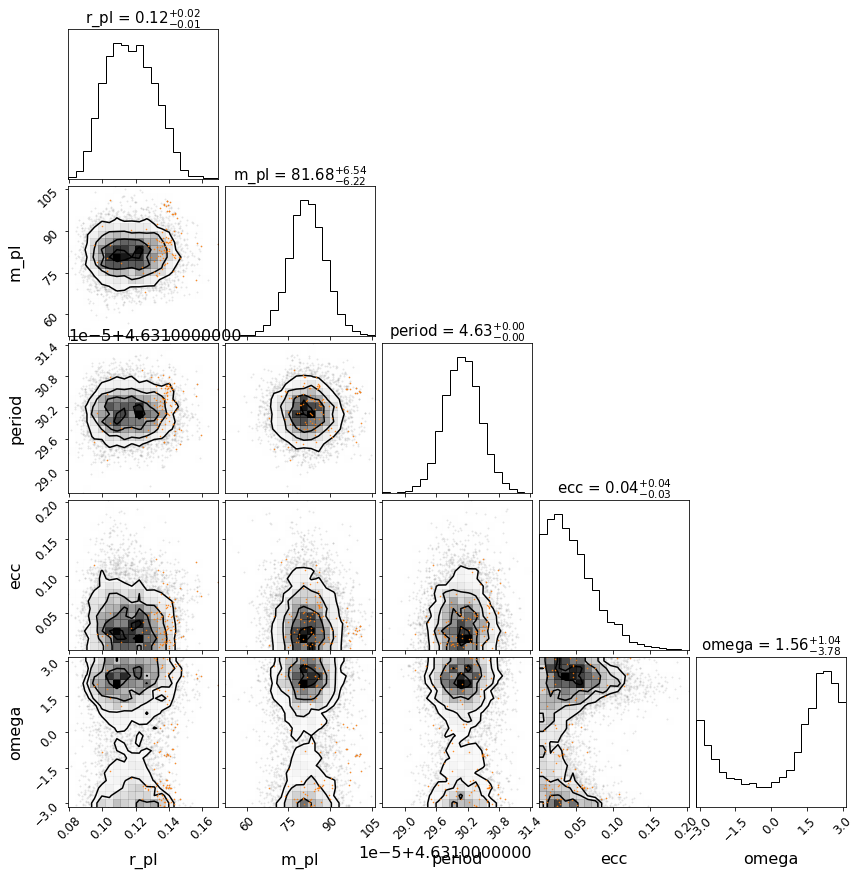

In [75]:
import corner

# figure = corner.corner(trace, var_names=['ecs', 'log_depth', 'b', 'log_m_pl', 'u_star'], 
#                         show_titles=True, title_kwargs={'fontsize':15}, divergences=True) # SAMPLED [logs, trend, log_sigma_rv, ecs, log_depth, b, 
#                                                                                             # log_period, log_m_pl, t0, r_star, m_star, u_star, mean]
figure = corner.corner(trace, var_names=['r_pl', 'm_pl', 'period', 'ecc', 'omega'], 
                        show_titles=True, title_kwargs={'fontsize':15}, divergences=True) # NOT SAMPLED
figure.subplots_adjust(right=1, top=1)
for ax in figure.get_axes():
    ax.tick_params(axis='both', labelsize=12)
# plt.savefig('trace_corner_1273_notsampled.png',dpi=200,bbox_inches='tight')

## Phase plots

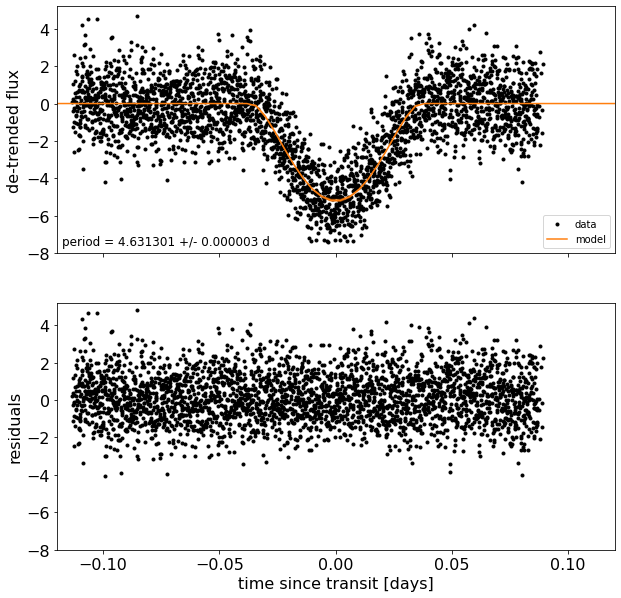

In [77]:
flat_samps = trace.posterior.stack(sample=("chain", "draw"))

# Get the posterior median orbital parameters
p_ = np.median(flat_samps["period"])
t0_ = np.median(flat_samps["t0"])

fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
# Plot the folded data
ax = axes[0]
x_fold2 = (x[mask] - t0_ + 0.5 * p_) % p_ - 0.5 * p_
ax.plot(x_fold2, y[mask] - map_soln['mean'], ".k", label="data", zorder=-1000)


# Plot the folded model
pred = np.percentile(flat_samps["lc_pred"], [16, 50, 84], axis=-1)
ax.plot(phase_lc, pred[1], color="C1", label="model")
art = ax.fill_between(
    phase_lc, pred[0], pred[2], color="C1", alpha=0.5, zorder=1000
)
art.set_edgecolor("none")

# Annotate the plot with the planet's period
txt = "period = {0:.6f} +/- {1:.6f} d".format(
    np.mean(flat_samps["period"].values), np.std(flat_samps["period"].values))

ax.annotate(
    txt,
    (0, 0),
    xycoords="axes fraction",
    xytext=(5, 5),
    textcoords="offset points",
    ha="left",
    va="bottom",
    fontsize=12,
)

ax.legend(fontsize=10, loc=4)
ax.set_ylabel("de-trended flux")
plt.xlim(-0.12, 0.12)
ax.set_ylim(-8,5.2)

ax = axes[1]
_= ax.plot(x_fold2, y[mask] - np.sum(extras, axis=-1), ".k", label="data", zorder=-1000)
ax.set_ylabel('residuals')
ax.set_xlabel("time since transit [days]")
ax.set_ylim(-8,5.2)
#plt.savefig('fit_transit_joint_1273.png',dpi=200,bbox_inches='tight')

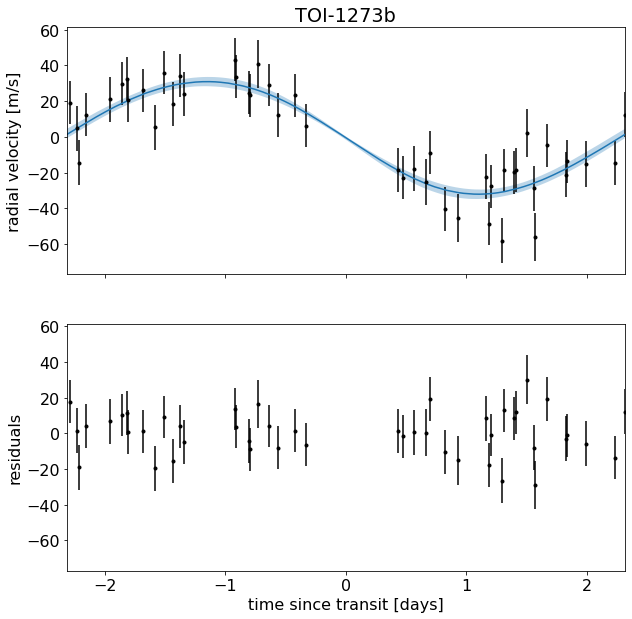

In [147]:
rv_jitter = np.exp(np.median(flat_samps['log_sigma_rv']))
bkg_ = np.median(flat_samps['bkg'].values, axis=-1)
rv_model_ = np.median(flat_samps['rv_model'].values, axis=-1)

# Plot the folded data
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True, sharey=True)
ax = axes[0]
x_fold = (x_rv - t0_ + 0.5 * p_) % p_ - 0.5 * p_
ax.errorbar(x_fold, y_rv - bkg_, yerr=np.sqrt(yerr_rv**2+rv_jitter**2), fmt=".k")

# Compute the posterior prediction for the folded RV model 
t_fold = (t_rv - t0_ + 0.5 * p_) % p_ - 0.5 * p_
inds = np.argsort(t_fold)
pred = np.percentile(trace.posterior["vrad_pred"].values[:, :, inds],[16, 50, 84],axis=(0, 1),)
ax.plot(t_fold[inds], pred[1], color="C0", label="model")
art = ax.fill_between(t_fold[inds], pred[0], pred[2], color="C0", alpha=0.3)
art.set_edgecolor("none")

#ax.set_legend(fontsize=10)
ax.set_xlim(-0.5 * p_, 0.5 * p_)
ax.set_ylabel("radial velocity [m/s]")
ax.set_title("TOI-1273b")

# Plot the folded residuals
ax = axes[1]
_= ax.errorbar(x_fold, y_rv-rv_model_ - bkg_, yerr=np.sqrt(yerr_rv**2+rv_jitter**2), fmt=".k", label='residuals')
ax.set_ylabel('residuals')
ax.set_xlabel("time since transit [days]")
plt.savefig('fit_rv_joint_1273.png',dpi=200,bbox_inches='tight')

We can also compute the posterior constraints on the planet densitiy.

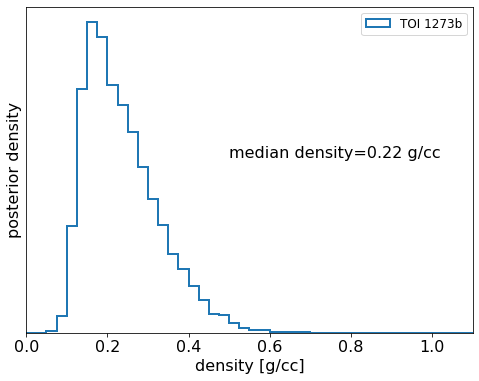

In [80]:
volume = 4 / 3 * np.pi * flat_samps["r_pl"].values ** 3
density = u.Quantity(flat_samps["m_pl"].values / volume, unit=u.M_earth / u.R_sun**3)
density = density.to(u.g / u.cm**3).value

bins = np.linspace(0, 1.1, 45)
plt.hist(
        density,
        bins,
        histtype="step",
        lw=2,
        label='TOI 1273b',
        density=True,)
plt.yticks([])
plt.text(0.5, 3, 'median density={:.2f} g/cc'.format(np.median(density)))
plt.legend(fontsize=12)
plt.xlim(bins[0], bins[-1])
plt.xlabel("density [g/cc]")
_ = plt.ylabel("posterior density")
#plt.savefig('density_joint_1273.png',dpi=200,bbox_inches='tight')